Importing and downloading the necessary libraries

In [ ]:
!pip install einops
!pip install torchinfo
!pip install timm
!pip install torchviz
import pandas as pd
import torch
from google.colab import drive
import io
import zipfile
from google.colab import drive
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
import os
import csv
import torch.optim as optim
import numpy as np
from einops import repeat
import matplotlib.pyplot as plt
from random import random
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import v2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from einops.layers.torch import Rearrange
import torch.utils.checkpoint as checkpoint
import torch.optim as optim
import numpy as np
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_

Working with the dataset

In [ ]:
drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Capstone project/dataImages.zip", 'r')
zip_ref.extractall()

Mounted at /content/drive/


In [ ]:
root_directory = "Dataset/Test"
with open("Test.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image Name", "Image Path", "Label"])
    for folder in ["Fake", "Real"]:
        folder_path = os.path.join(root_directory, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            writer.writerow([filename, image_path, folder])
test_df = pd.read_csv("Test.csv")
test_df = test_df.sample(frac = 1)
test_df

,Image Name,Image Path,Label
5795,real_747.jpg,Dataset/Test/Real/real_747.jpg,Real
666,fake_1679.jpg,Dataset/Test/Fake/fake_1679.jpg,Fake
2128,fake_2697.jpg,Dataset/Test/Fake/fake_2697.jpg,Fake
4886,fake_1012.jpg,Dataset/Test/Fake/fake_1012.jpg,Fake
5908,real_1939.jpg,Dataset/Test/Real/real_1939.jpg,Real
...,...,...,...
8761,real_1685.jpg,Dataset/Test/Real/real_1685.jpg,Real
9915,real_5219.jpg,Dataset/Test/Real/real_5219.jpg,Real
9769,real_2735.jpg,Dataset/Test/Real/real_2735.jpg,Real
4591,fake_481.jpg,Dataset/Test/Fake/fake_481.jpg,Fake


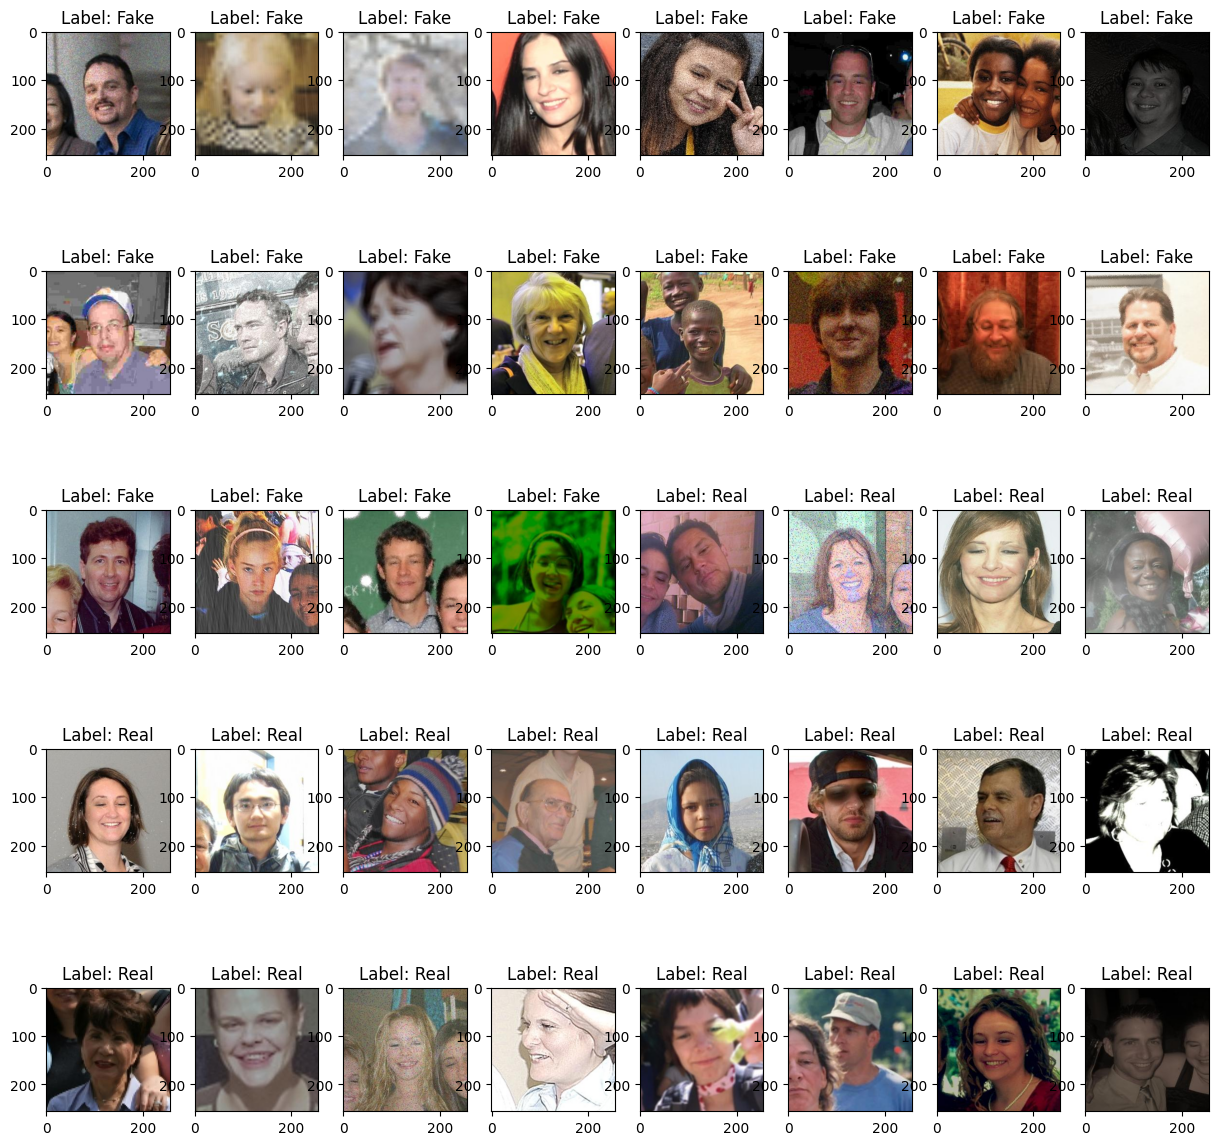

In [ ]:
def show_images(images, num_samples=39, cols=8):
    plt.figure(figsize=(15,15))
    ids = int(len(test_df) / num_samples)
    for i,p in enumerate(images['Image Path']):
        img = plt.imread(p)
        if i % ids == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/ids) + 1)
            plt.title(f'Label: {test_df["Label"][i]}')
            plt.imshow(to_pil_image(img))

show_images(test_df)

In [ ]:
from torchvision import datasets
transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
train = datasets.ImageFolder("Dataset/Train", transform=transform)
pred = datasets.ImageFolder("Dataset/Test", transform=transform)
val = datasets.ImageFolder("Dataset/Validation", transform=transform)
train_dataloader = DataLoader(train, shuffle=True)
test_dataloader = DataLoader(val, shuffle=True)
test_set = DataLoader(pred, shuffle=True)
class_names = train.classes

torch.Size([3, 224, 224]) tensor(0)


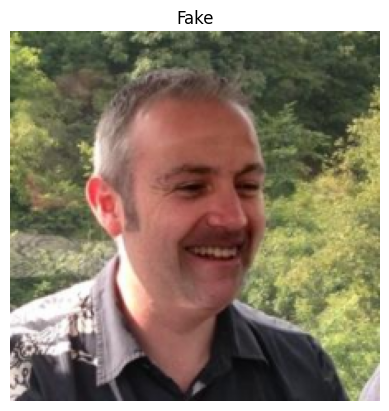

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
print(image.shape, label)
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

Number of patches =  torch.Size([196, 16, 16, 3])


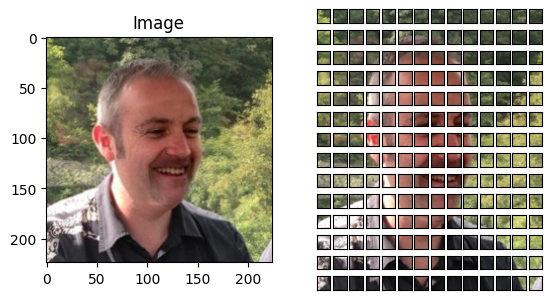

In [ ]:
fig = plt.figure()

gridspec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gridspec[0])
ax1.set(title='Image')

# display image
img = image.permute(1,2,0)
ax1.imshow(img)
P = 16
patches = img.reshape(img.shape[0]//P, P, img.shape[1]//P, P, 3).swapaxes(1, 2).reshape(-1, P, P, 3)
print("Number of patches = ",patches.shape)
subgridspec = gridspec[1].subgridspec(14, 14, hspace=-0.8)

# display patches
for i in range(14):
    for j in range(14):
        num = i * 14 + j
        ax = fig.add_subplot(subgridspec[i, j])
        ax.set(xticks=[], yticks=[])
        ax.imshow(patches[num])

Model Implementation

In [ ]:
def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }
default_cfgs = {
    'cswin_224': _cfg(),
    'cswin_384': _cfg(crop_pct=1.0)
}

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [ ]:
class LePEAttention(nn.Module):
    def __init__(self, dim, resolution, idx, split_size=7, dim_out=None, num_heads=8, attn_drop=0., proj_drop=0., qk_scale=None):
        super().__init__()
        self.dim = dim
        self.dim_out = dim_out or dim
        self.resolution = resolution
        self.split_size = split_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        if idx == -1:
            H_sp, W_sp = self.resolution, self.resolution
        elif idx == 0:
            H_sp, W_sp = self.resolution, self.split_size
        elif idx == 1:
            W_sp, H_sp = self.resolution, self.split_size
        else:
            print ("ERROR MODE", idx)
            exit(0)
        self.H_sp = H_sp
        self.W_sp = W_sp
        stride = 1
        self.get_v = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1,groups=dim)

        self.attn_drop = nn.Dropout(attn_drop)

    def im2cswin(self, x):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2,-1).contiguous().view(B, C, H, W)
        x = img2windows(x, self.H_sp, self.W_sp)
        x = x.reshape(-1, self.H_sp* self.W_sp, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3).contiguous()
        return x

    def get_lepe(self, x, func):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2,-1).contiguous().view(B, C, H, W)

        H_sp, W_sp = self.H_sp, self.W_sp
        x = x.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous().reshape(-1, C, H_sp, W_sp) ### B', C, H', W'

        lepe = func(x) ### B', C, H', W'
        lepe = lepe.reshape(-1, self.num_heads, C // self.num_heads, H_sp * W_sp).permute(0, 1, 3, 2).contiguous()

        x = x.reshape(-1, self.num_heads, C // self.num_heads, self.H_sp* self.W_sp).permute(0, 1, 3, 2).contiguous()
        return x, lepe

    def forward(self, qkv):
        """
        x: B L C
        """
        q,k,v = qkv[0], qkv[1], qkv[2]

        ### Img2Window
        H = W = self.resolution
        B, L, C = q.shape
        assert L == H * W, "flatten img_tokens has wrong size"

        q = self.im2cswin(q)
        k = self.im2cswin(k)
        v, lepe = self.get_lepe(v, self.get_v)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))  # B head N C @ B head C N --> B head N N
        attn = nn.functional.softmax(attn, dim=-1, dtype=attn.dtype)
        attn = self.attn_drop(attn)

        x = (attn @ v) + lepe
        x = x.transpose(1, 2).reshape(-1, self.H_sp* self.W_sp, C)  # B head N N @ B head N C

        ### Window2Img
        x = windows2img(x, self.H_sp, self.W_sp, H, W).view(B, -1, C)  # B H' W' C
        return x

In [ ]:
class CSWinBlock(nn.Module):

    def __init__(self, dim, reso, num_heads,
                 split_size=7, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 last_stage=False):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.patches_resolution = reso
        self.split_size = split_size
        self.mlp_ratio = mlp_ratio
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.norm1 = norm_layer(dim)

        if self.patches_resolution == split_size:
            last_stage = True
        if last_stage:
            self.branch_num = 1
        else:
            self.branch_num = 2
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(drop)

        if last_stage:
            self.attns = nn.ModuleList([
                LePEAttention(
                    dim, resolution=self.patches_resolution, idx = -1,
                    split_size=split_size, num_heads=num_heads, dim_out=dim,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])
        else:
            self.attns = nn.ModuleList([
                LePEAttention(
                    dim//2, resolution=self.patches_resolution, idx = i,
                    split_size=split_size, num_heads=num_heads//2, dim_out=dim//2,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])


        mlp_hidden_dim = int(dim * mlp_ratio)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, act_layer=act_layer, drop=drop)
        self.norm2 = norm_layer(dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """

        H = W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        img = self.norm1(x)
        qkv = self.qkv(img).reshape(B, -1, 3, C).permute(2, 0, 1, 3)

        if self.branch_num == 2:
            x1 = self.attns[0](qkv[:,:,:,:C//2])
            x2 = self.attns[1](qkv[:,:,:,C//2:])
            attened_x = torch.cat([x1,x2], dim=2)
        else:
            attened_x = self.attns[0](qkv)
        attened_x = self.proj(attened_x)
        x = x + self.drop_path(attened_x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

def img2windows(img, H_sp, W_sp):
    """
    img: B C H W
    """
    B, C, H, W = img.shape
    img_reshape = img.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
    img_perm = img_reshape.permute(0, 2, 4, 3, 5, 1).contiguous().reshape(-1, H_sp* W_sp, C)
    return img_perm

def windows2img(img_splits_hw, H_sp, W_sp, H, W):
    """
    img_splits_hw: B' H W C
    """
    B = int(img_splits_hw.shape[0] / (H * W / H_sp / W_sp))

    img = img_splits_hw.view(B, H // H_sp, W // W_sp, H_sp, W_sp, -1)
    img = img.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return img

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = img2windows(image.unsqueeze(0),8,8)
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([784, 64, 3])


In [ ]:
class Merge_Block(nn.Module):
    def __init__(self, dim, dim_out, norm_layer=nn.LayerNorm):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim_out, 3, 2, 1)
        self.norm = norm_layer(dim_out)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = self.conv(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()
        x = self.norm(x)

        return x

In [ ]:
class CSWinTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=96, depth=[2,2,6,2], split_size = [3,5,7],
                 num_heads=[6,12,12,24], mlp_ratio=4., qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, use_chk=False):
        super().__init__()
        self.use_chk = use_chk
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        heads=num_heads

        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim, 7, 4, 2),
            Rearrange('b c h w -> b (h w) c', h = img_size//4, w = img_size//4),
            nn.LayerNorm(embed_dim)
        )

        curr_dim = embed_dim
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, np.sum(depth))]  # stochastic depth decay rule
        self.stage1 = nn.ModuleList([
            CSWinBlock(
                dim=curr_dim, num_heads=heads[0], reso=img_size//4, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[0],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth[0])])

        self.merge1 = Merge_Block(curr_dim, curr_dim*2)
        curr_dim = curr_dim*2
        self.stage2 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[1], reso=img_size//8, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:1])+i], norm_layer=norm_layer)
            for i in range(depth[1])])

        self.merge2 = Merge_Block(curr_dim, curr_dim*2)
        curr_dim = curr_dim*2
        temp_stage3 = []
        temp_stage3.extend(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[2], reso=img_size//16, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[2],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:2])+i], norm_layer=norm_layer)
            for i in range(depth[2])])

        self.stage3 = nn.ModuleList(temp_stage3)

        self.merge3 = Merge_Block(curr_dim, curr_dim*2)
        curr_dim = curr_dim*2
        self.stage4 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[3], reso=img_size//32, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[-1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:-1])+i], norm_layer=norm_layer, last_stage=True)
            for i in range(depth[-1])])

        self.norm = norm_layer(curr_dim)
        # Classifier head
        self.head = nn.Linear(curr_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.head.weight, std=0.02)
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        if self.num_classes != num_classes:
            print ('reset head to', num_classes)
            self.num_classes = num_classes
            self.head = nn.Linear(self.out_dim, num_classes) if num_classes > 0 else nn.Identity()
            self.head = self.head.cuda()
            trunc_normal_(self.head.weight, std=.02)
            if self.head.bias is not None:
                nn.init.constant_(self.head.bias, 0)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.stage1_conv_embed(x)
        for blk in self.stage1:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        for pre, blocks in zip([self.merge1, self.merge2, self.merge3],
                               [self.stage2, self.stage3, self.stage4]):
            x = pre(x)
            for blk in blocks:
                if self.use_chk:
                    x = checkpoint.checkpoint(blk, x)
                else:
                    x = blk(x)
        x = self.norm(x)
        return torch.mean(x, dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [ ]:
def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict

In [ ]:
def CSWin_model(pretrained=False, **kwargs):
    model = CSWinTransformer(patch_size=4, embed_dim=144, depth=[2,4,8,2],
        split_size=[1,2,7,7], num_heads=[6,12,24,24], mlp_ratio=4., **kwargs)
    model.default_cfg = default_cfgs['cswin_224']
    return model

In [ ]:
transformer_encoder_block = CSWinTransformer(num_classes=len(class_names),patch_size=4, embed_dim=144, depth=[2,4,8,2],split_size=[1,2,7,7], num_heads=[6,12,24,24], mlp_ratio=4)
from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
CSWinTransformer (CSWinTransformer)           [1, 3, 224, 224]     [1, 2]               --                   True
├─Sequential (stage1_conv_embed)              [1, 3, 224, 224]     [1, 3136, 144]       --                   True
│    └─Conv2d (0)                             [1, 3, 224, 224]     [1, 144, 56, 56]     21,312               True
│    └─Rearrange (1)                          [1, 144, 56, 56]     [1, 3136, 144]       --                   --
│    └─LayerNorm (2)                          [1, 3136, 144]       [1, 3136, 144]       288                  True
├─ModuleList (stage1)                         --                   --                   --                   True
│    └─CSWinBlock (0)                         [1, 3136, 144]       [1, 3136, 144]       --                   True
│    │    └─LayerNorm (norm1)                 [1, 3136, 144]       [1, 3136, 144]    

Hyper-parameter tuning

In [ ]:
%pip install bayesian-optimization==1.4.1
from statistics import mean
from bayes_opt import BayesianOptimization
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
score_acc = make_scorer(accuracy_score)

params_nn ={
    'weight_d':(0.01,1),
    'learning_rate':(10e-7, 1),
    'epochs':(20, 100),
    'drop_val':(0,1)
}

def nn_cl_bo(learning_rate, epochs, weight_d, drop_val):
    model = CSWin_model(num_classes=2,drop_rate=drop_val)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_d)
    loss_fn = torch.nn.CrossEntropyLoss()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    epochs=round(epochs)
    score = []
    model.to(device)
    for epoch in range(epochs):
          train_loss, train_acc = train_step(model=model, loss_fn=loss_fn, optimizer=optimizer, device=device)
          test_loss, test_acc = test_step(model=model, loss_fn=loss_fn, device=device)
          score.append(test_acc)
    return mean(score)

nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/u

ModuleNotFoundError: No module named 'bayes_opt'

Model Demonstration

In [ ]:
from torchvision import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,f1_score
transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
pred = datasets.ImageFolder("Dataset/Test", transform=transform)
test_dataloader = DataLoader(pred, shuffle=True)
if torch.cuda.is_available():
  device = "cuda"
  model = torch.load("/content/drive/MyDrive/Capstone project/Cswinbackup2 (5).pt")
  start = time.perf_counter()
  with open("predictions.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["actual", "probability", "prediction"])
    for b, (i, j) in enumerate(test_set):
            print(b)
            i = i.to(device)
            test_pred_logits = model(i)
            prob = torch.softmax(test_pred_logits, dim=1)
            pred = torch.argmax(prob, dim=1)
            pro = prob.cpu()
            pre = pred.cpu()
            writer = csv.writer(csvfile)
            writer.writerow([j.detach().numpy()[0], str(pro.detach().numpy()[0]), pre.detach().numpy()[0]])
  stop = time.perf_counter()
  print("Time elapsed: ", stop - start)
else:
  device = "cpu"
  model = torch.load("/content/drive/MyDrive/Capstone project/Cswinbackup2 (5).pt",map_location=torch.device('cpu'))
  start = time.perf_counter()
  with open("predictions.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["actual", "probability", "prediction"])
    for b, (i, j) in enumerate(test_set):
            test_pred_logits = model(i)
            prob = torch.softmax(test_pred_logits, dim=1)
            pred = torch.argmax(prob, dim=1)
            writer = csv.writer(csvfile)
            writer.writerow([j.detach().numpy()[0], str(prob.detach().numpy()[0]), pred.detach().numpy()[0]])
  stop = time.perf_counter()
  print("Time elapsed: ", stop - start)

Streaming output truncated to the last 5000 lines.
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576

In [ ]:
import ast
import re
df = pd.read_csv("predictions.csv")
probability = []
for i in df['probability']:
  j = re.sub(' +', ' ',i[1:-1])
  j = j[:-1]
  probs = [float(p) for p in j.split(' ')]
  probability.append(probs)
df['probability'] = probability
df

,actual,probability,prediction
0,0,"[0.07759276, 0.9224072]",1
1,1,"[0.04131701, 0.9586829]",1
2,0,"[0.13149163, 0.8685084]",1
3,1,"[0.34224632, 0.6577537]",1
4,0,"[0.96456414, 0.0354359]",0
...,...,...,...
10900,1,"[0.03998021, 0.9600198]",1
10901,0,"[0.34843215, 0.6515679]",1
10902,0,"[0.9496116, 0.050388]",0
10903,0,"[0.93897736, 0.0610226]",0


model AUC score: 0.8854845917996504


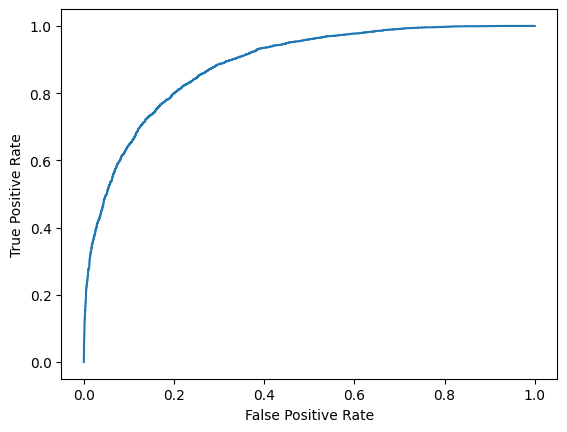

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
prob = []
act = []
prediction = []
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
for i in df['actual']:
  act.append(i)
for i in range(len(df['probability'])):
  prob.append(df['probability'][i][1])
for i in df['prediction']:
  prediction.append(i)
plot_roc_curve(act, prob)
print(f'model AUC score: {roc_auc_score(act, prob)}')

accuracy score: 0.7958734525447043
F1 score: 0.808301756803307
Precision score: 0.7570575899338603
Recall score: 0.8669868834287826
Confusion matrix


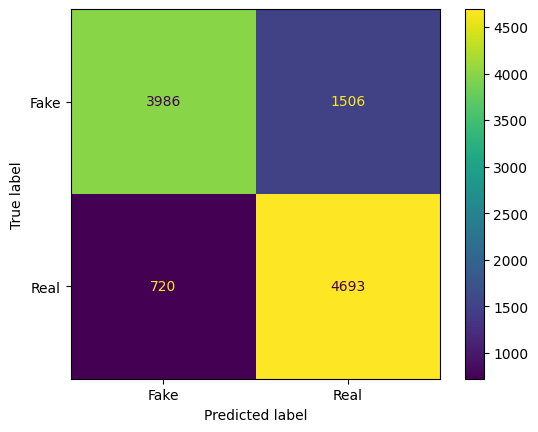

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score
print(f'accuracy score: {accuracy_score(act, prediction)}')
print(f'F1 score: {f1_score(act, prediction)}')
print(f'Precision score: {precision_score(act, prediction)}')
print(f'Recall score: {recall_score(act, prediction)}')
cf_mat = confusion_matrix(act, prediction)
print('Confusion matrix')
ConfusionMatrixDisplay(confusion_matrix=cf_mat,display_labels=["Fake","Real"]).plot()

Text(0, 0.5, 'Precision')

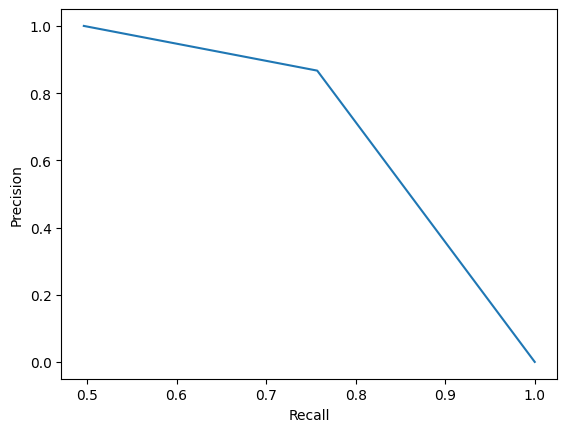

In [ ]:
from sklearn.metrics import precision_recall_curve
prec, rec, threshold = precision_recall_curve(act, prediction)
plt.plot(prec, rec)
plt.xlabel('Recall')
plt.ylabel('Precision')

(-0.5, 255.5, 255.5, -0.5)

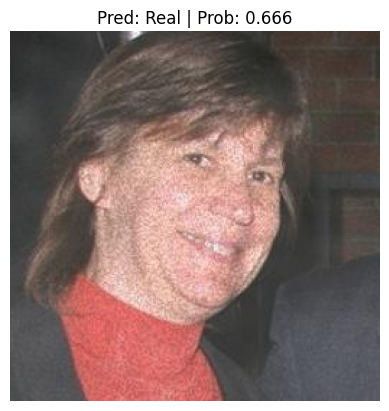

In [ ]:
from typing import List, Tuple

from PIL import Image

#Real image path: Dataset/Test/Real/real_1504.jpg
#Fake image path: Dataset/Test/Fake/fake_2848.jpg

device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = "Dataset/Test/Real/real_1504.jpg"
class_names = ["Fake","Real"]
image_size = (224,224)
img = Image.open(image_path)
if transform is not None:
    image_transform = transform
else:
    image_transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
model.to(device)
model.eval()
with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))
target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
plt.figure()
plt.imshow(img)
plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
plt.axis(False)

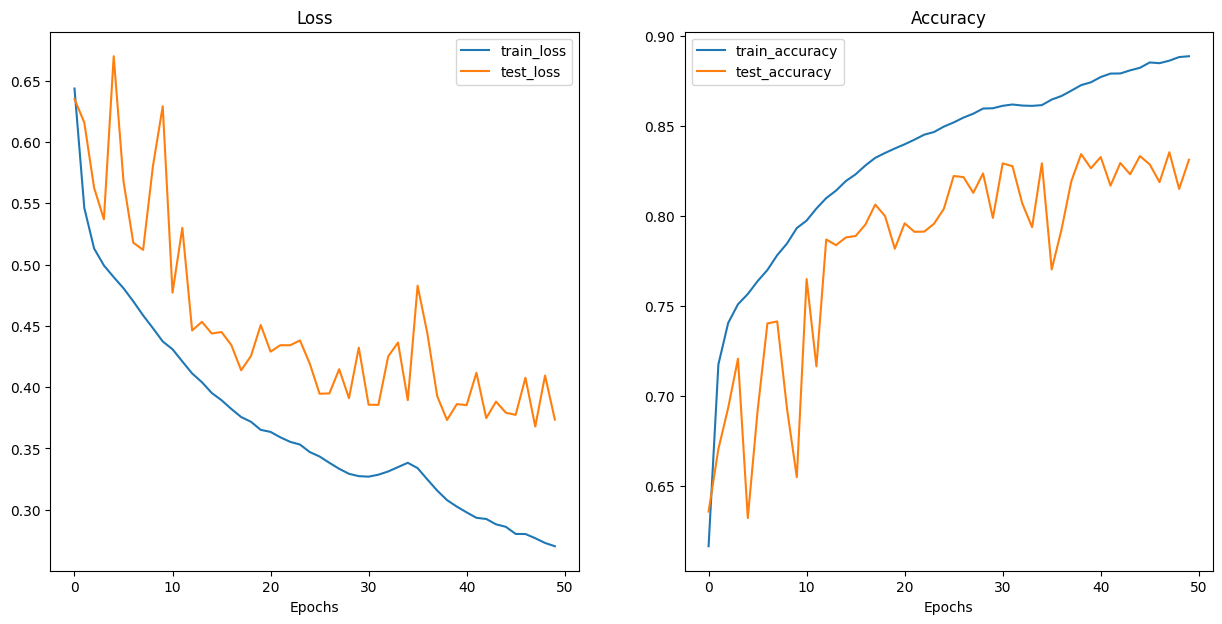

In [ ]:
from typing import List
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_csv("/content/Results (9).csv")

loss = results["train_loss"]
test_loss = results["test_loss"]
accuracy = results["train_acc"]
test_accuracy = results["test_acc"]
epochs = range(len(results["train_loss"]))
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()